<img src="https://ga-dash.s3.amazonaws.com/production/assets/logo-9f88ae6c9c3871690e33280fcf557f33.png" style="float: left; margin: 15px">

## Autocorrelation and properties of time series data

Week 10 | Lesson 2.3

---

We looking at the Rossman store data to practice more timeseries plotting, look at different ways of modeling the mean (or median, etc.) of timeseries, and learn about the autocorrelation of a vector.

Trends, moving averages, and autocorrelation are essential concepts to cover before jumping into modeling timeseries with ARIMA models.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime

sns.set_style('whitegrid')

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

---

## Timeseries trends

An example of an upward trend:

![](./assets/images/trend-line2.png)

Trend may “change direction” when it goes from an increasing trend to a decreasing trend. Trend can only be measured in the scope of the data collected; there may be trends that are unmeasureable if the data is not complete.

---

## Seasonality

When there are patterns that repeat over known, fixed periods of time within the data set it is considered to be **seasonality**.

A seasonal pattern exists when a series is influenced by factors relating to the cyclic nature of time - i.e. time of month, quarter, year, etc. 

Seasonality is of a fixed and known period, otherwise it is not truly seasonality, and must be either attributed to another factor or counted as a set of anomalous events in the data.

![](./assets/images/seasonality_decreasing_trend.png)

---

## Rossman store data

Load the rossman store data, then convert the date to datetime format and make it the index of the DataFrame:

In [2]:
data = pd.read_csv('/Users/kiefer/github-repos/DSI-SF-2/datasets/rossman_stores/rossmann.csv', skipinitialspace=True)

//anaconda/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2705: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
data.head(3)

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1


In [4]:
data.dtypes

Store             int64
DayOfWeek         int64
Date             object
Sales             int64
Customers         int64
Open              int64
Promo             int64
StateHoliday     object
SchoolHoliday     int64
dtype: object

In [5]:
data.columns = ['store','day_of_week','date','sales','customers','open','promo','state_holiday','school_holiday']

In [6]:
data.day_of_week.unique()

array([5, 4, 3, 2, 1, 7, 6])

In [7]:
data.date = pd.to_datetime(data.date)

In [8]:
data.set_index('date', inplace=True)

data['year'] = data.index.year
data['month'] = data.index.month

In [9]:
data.head(3)

,store,day_of_week,sales,customers,open,promo,state_holiday,school_holiday,year,month
date,,,,,,,,,,
2015-07-31,1,5,5263,555,1,1,0,1,2015,7
2015-07-31,2,5,6064,625,1,1,0,1,2015,7
2015-07-31,3,5,8314,821,1,1,0,1,2015,7


In [10]:
stores = data[data.store.isin([1,4,9])]

**Plot a seaborn factorplot `kind='box'` for stores 1, 4, and 9 with the x-axis the day of the week and the y-axis the sales:**

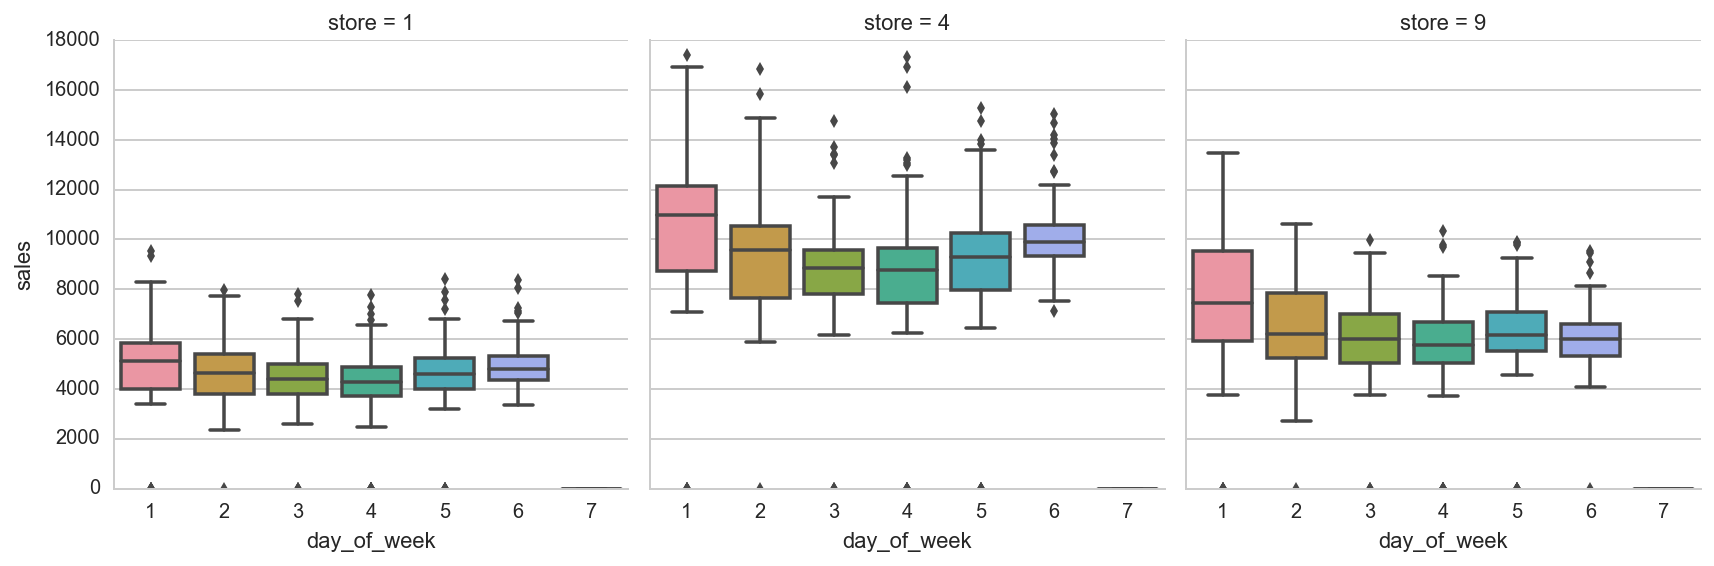

In [11]:
sns.factorplot(x='day_of_week', y='sales',col='store', kind='box', data=stores)

**Plot the sales and customer timeseries for store 1 when open:**

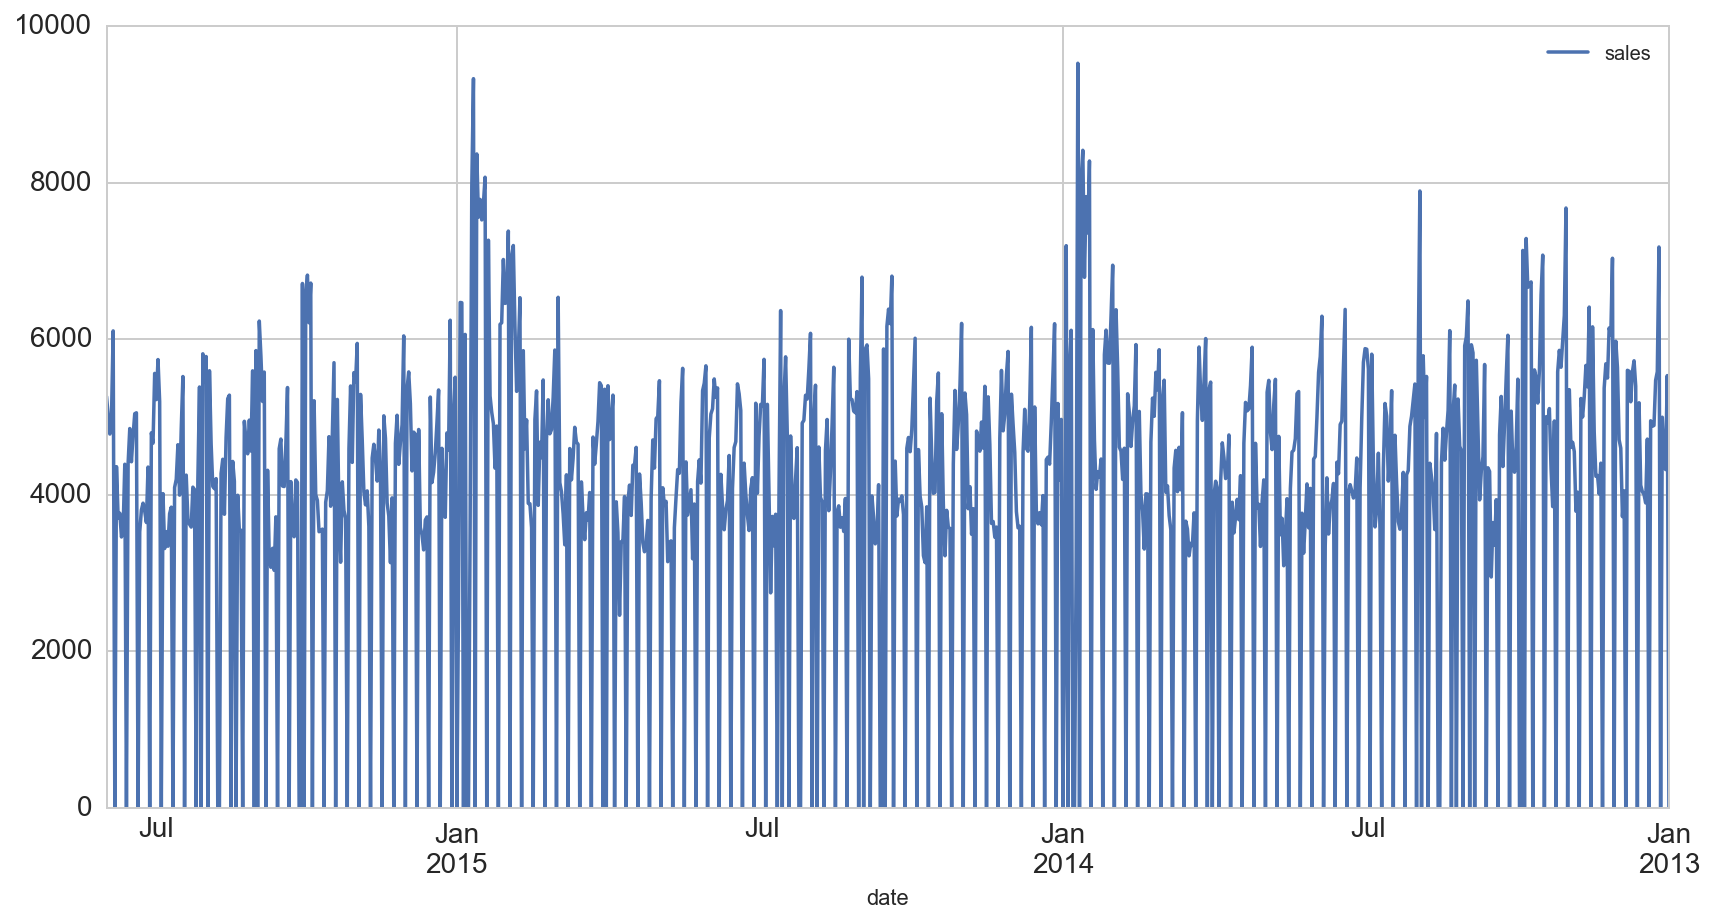

In [15]:
# Filter to store 1
store1_data = stores[(stores.store == 1)]
store1_data[['sales']].plot(figsize=(14,7), fontsize=14)

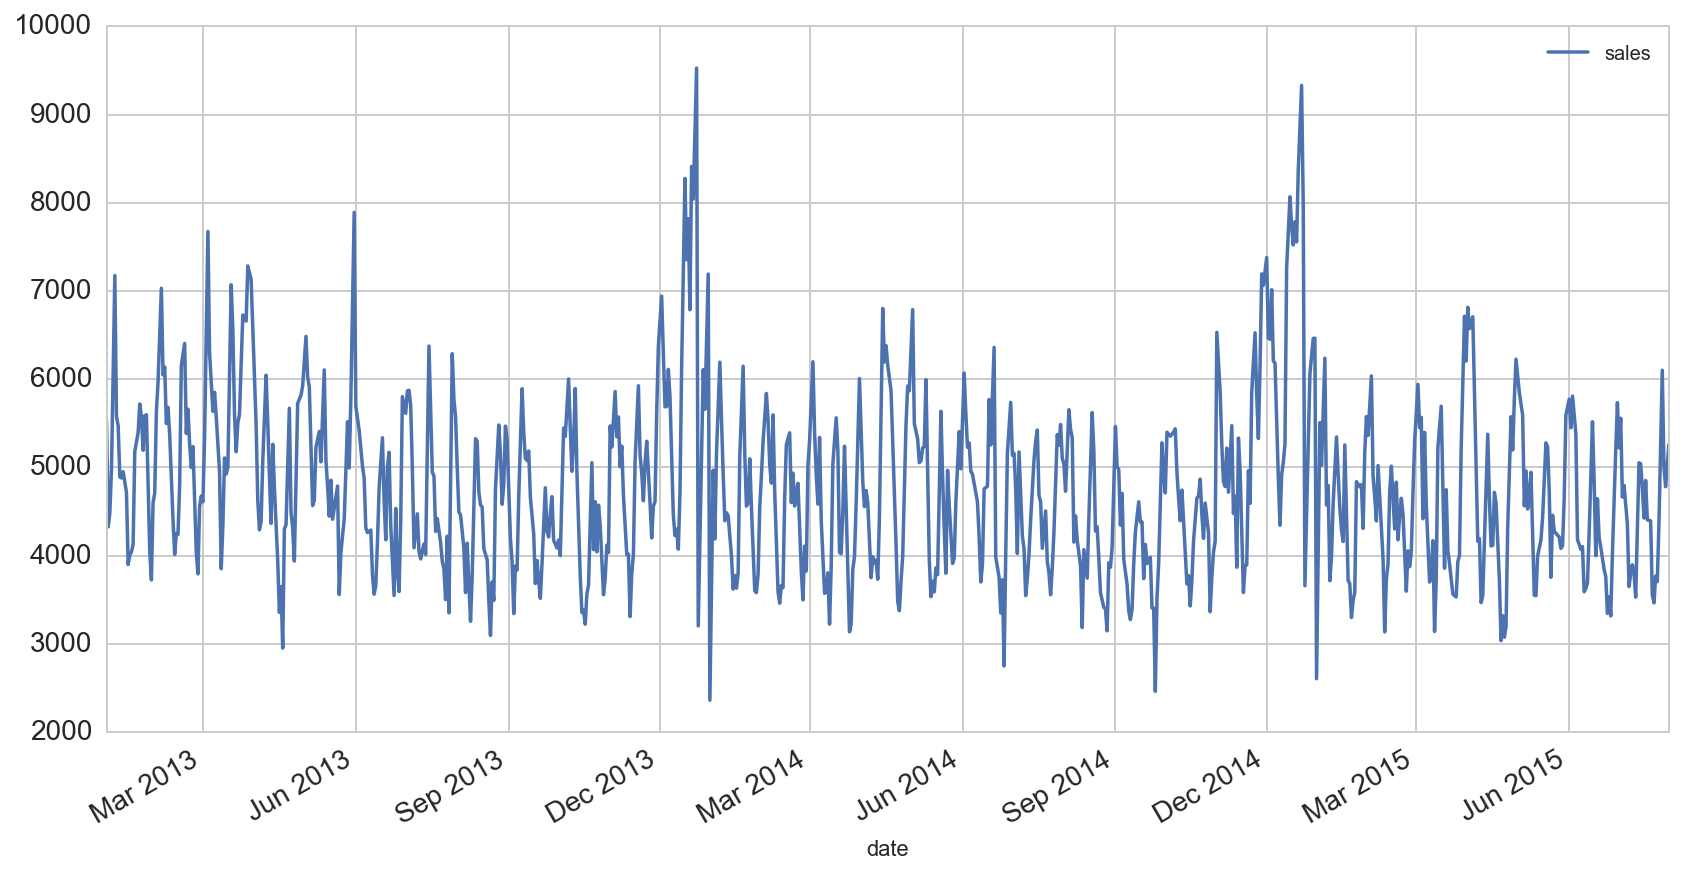

In [13]:
# Filter to store 1 when it was open
store1_open_data = stores[(stores.store == 1) & (stores.open == 1)]
store1_open_data[['sales']].plot(figsize=(14,7), fontsize=14)

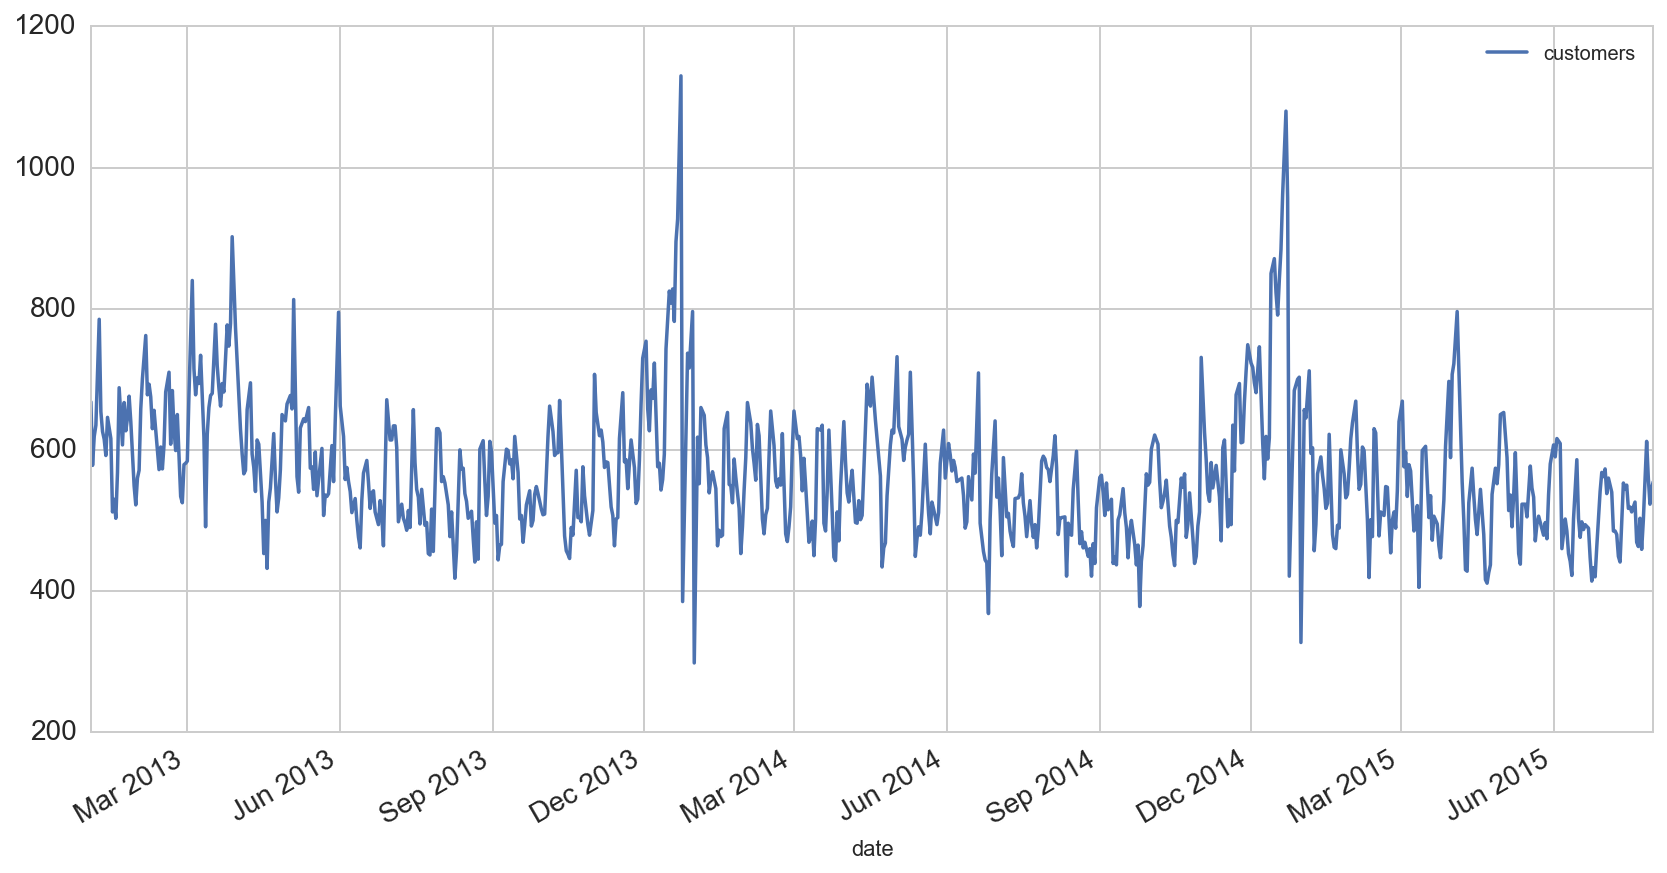

In [14]:
store1_open_data[['customers']].plot(figsize=(14,7), fontsize=14)

---

## Rolling means (and medians, etc.)

The "rolling mean" or median takes a specified lag and uses the current time point and time points prior up to the specified lag to calculate the statistic.


In [17]:
store1_mask = (stores.store == 1) & (stores.open == 1)
date_ticks1 = stores[store1_mask].index.to_pydatetime()


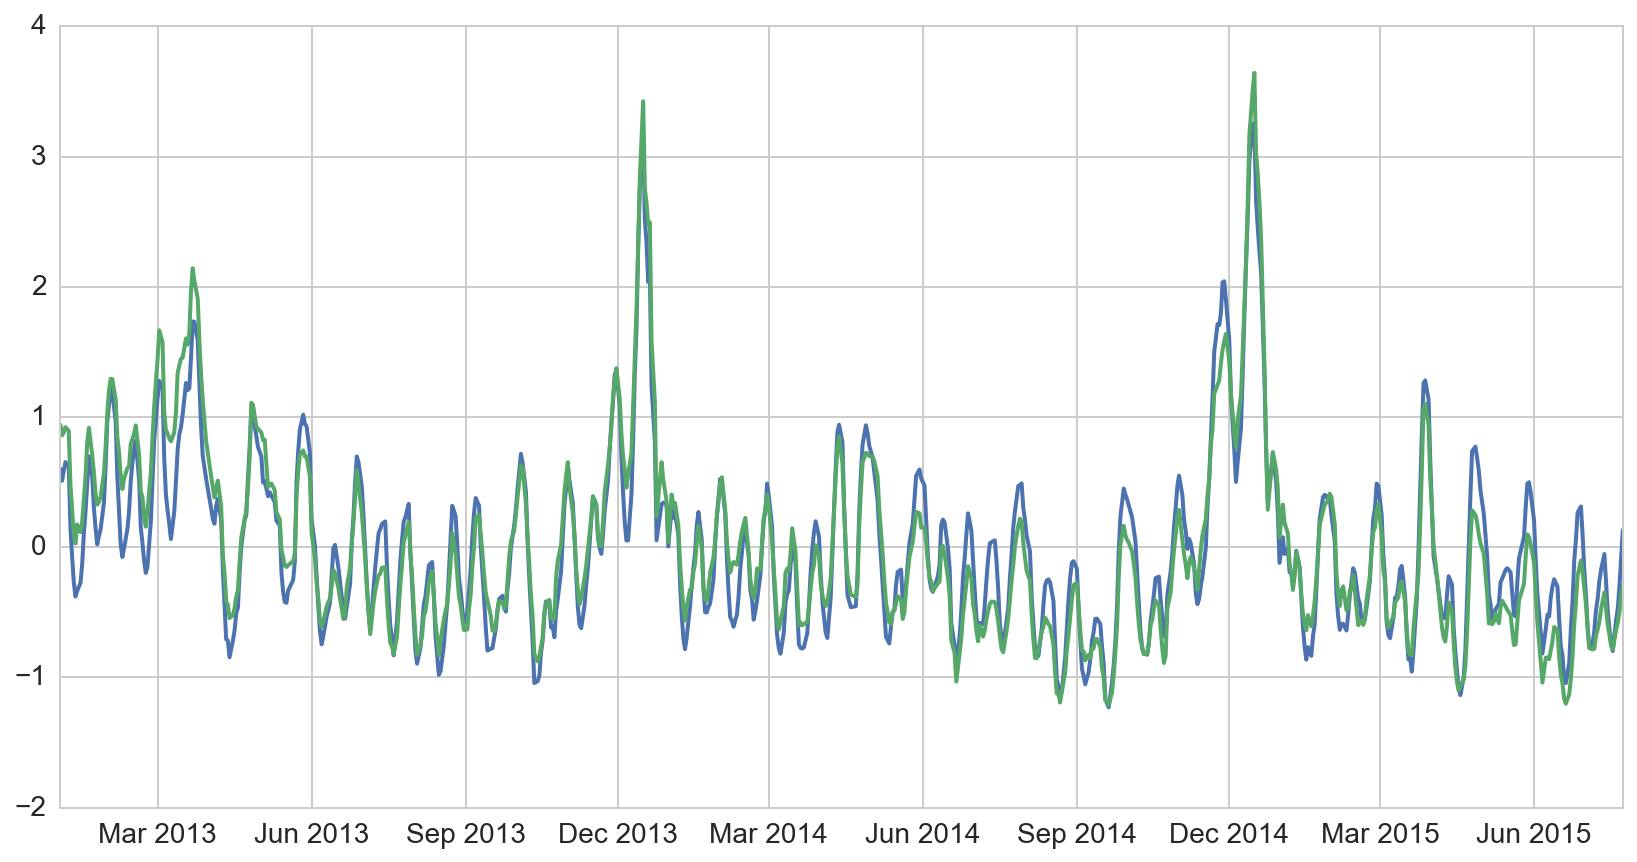

In [21]:
s1_sales = stores[store1_mask]['sales']
s1_cust = stores[store1_mask]['customers']

s1_sales = (s1_sales - s1_sales.mean()) / s1_sales.std()
s1_cust = (s1_cust - s1_cust.mean()) / s1_cust.std()

s1_sales_rollmean = s1_sales.rolling(window=7).mean()
s1_cust_rollmean = s1_cust.rolling(window=7).mean()

plt.figure(figsize=(14,7))

plt.plot(date_ticks1, s1_sales_rollmean, alpha=1, lw=2)
plt.plot(date_ticks1, s1_cust_rollmean, alpha=1, lw=2)

plt.tick_params(labelsize=14)

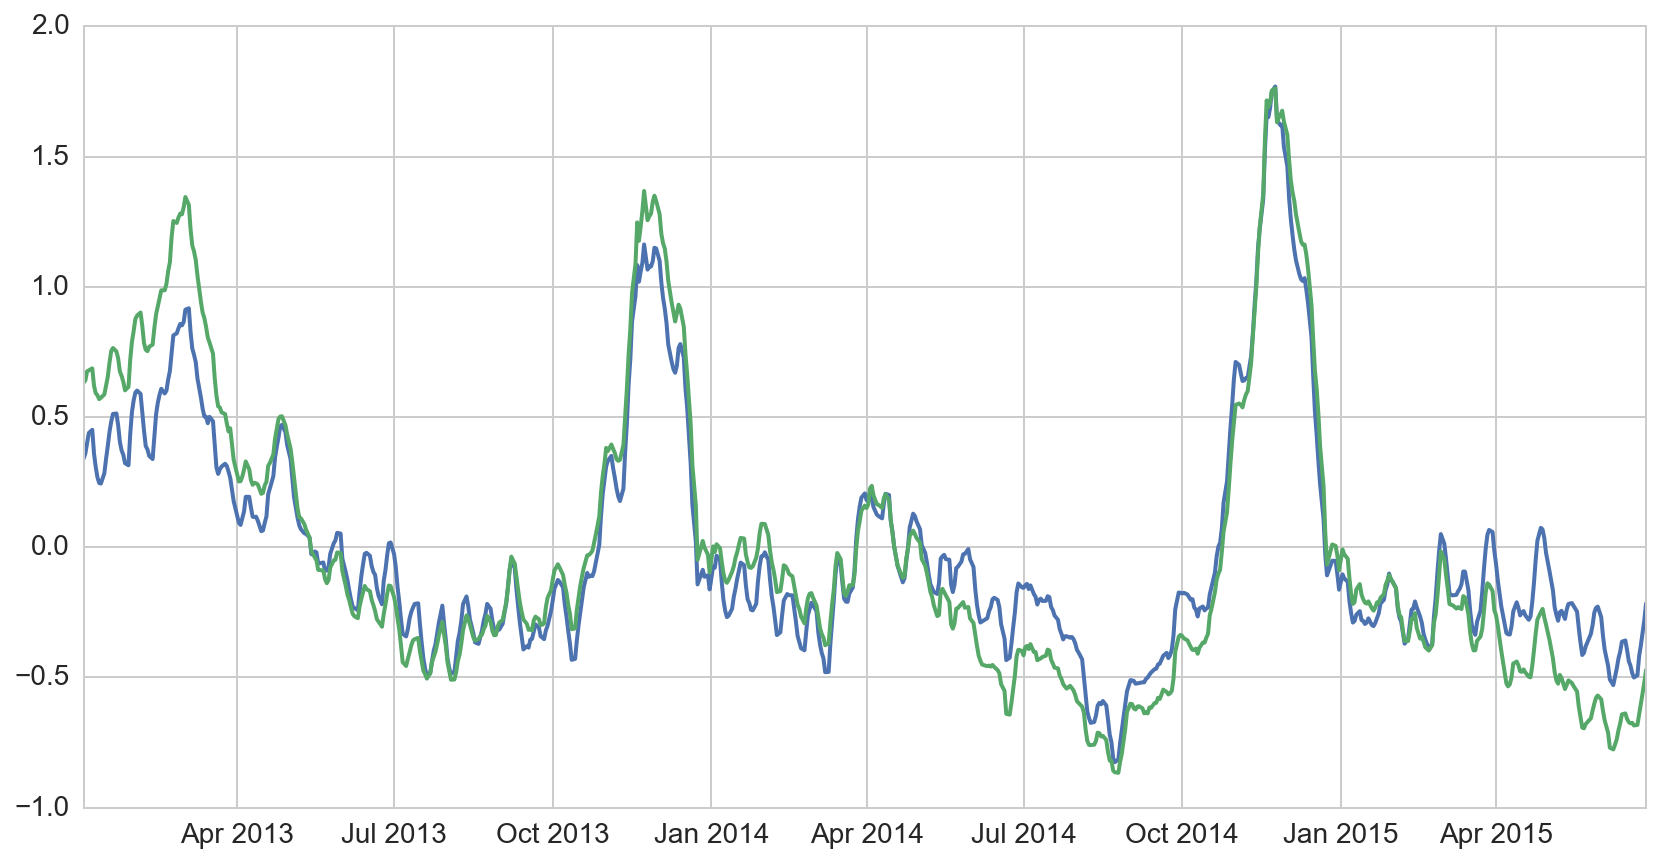

In [20]:
s1_sales_rollmean = s1_sales.rolling(window=30).mean()
s1_cust_rollmean = s1_cust.rolling(window=30).mean()

plt.figure(figsize=(14,7))

plt.plot(date_ticks1, s1_sales_rollmean, alpha=1, lw=2)
plt.plot(date_ticks1, s1_cust_rollmean, alpha=1, lw=2)

plt.tick_params(labelsize=14)

### Parameters for `rolling` functions

**`rolling().mean()`** (as well as **`rolling().median()`**) can take these parameters:

- the first is the series to aggregate
- **`window`** is the number of days to include in the average
- **`center`** is whether the window should be centered on the date or use data prior to that date
- **`freq`** is on what level to roll-up the averages to (as used in **`resample`**). Either **`D`** for day, **`M`** for month or **`A`** for year, etc.



**Calculate the weekly rolling median of sales for store 1 in 2014, using a weekly time period with an order 2 window:**

In [25]:
# Resample to have the daily average over all stores
s1_2014 = data[(data.store == 1) & (data.year == 2014)]

weekly_store_sales = s1_2014[['sales']].resample('W').sum().rolling(window=2, center=True).median()

weekly_store_sales.head()

,sales
date,
2014-01-05,NaN
2014-01-12,22166.0
2014-01-19,26977.0
2014-01-26,27028.0
2014-02-02,27910.0


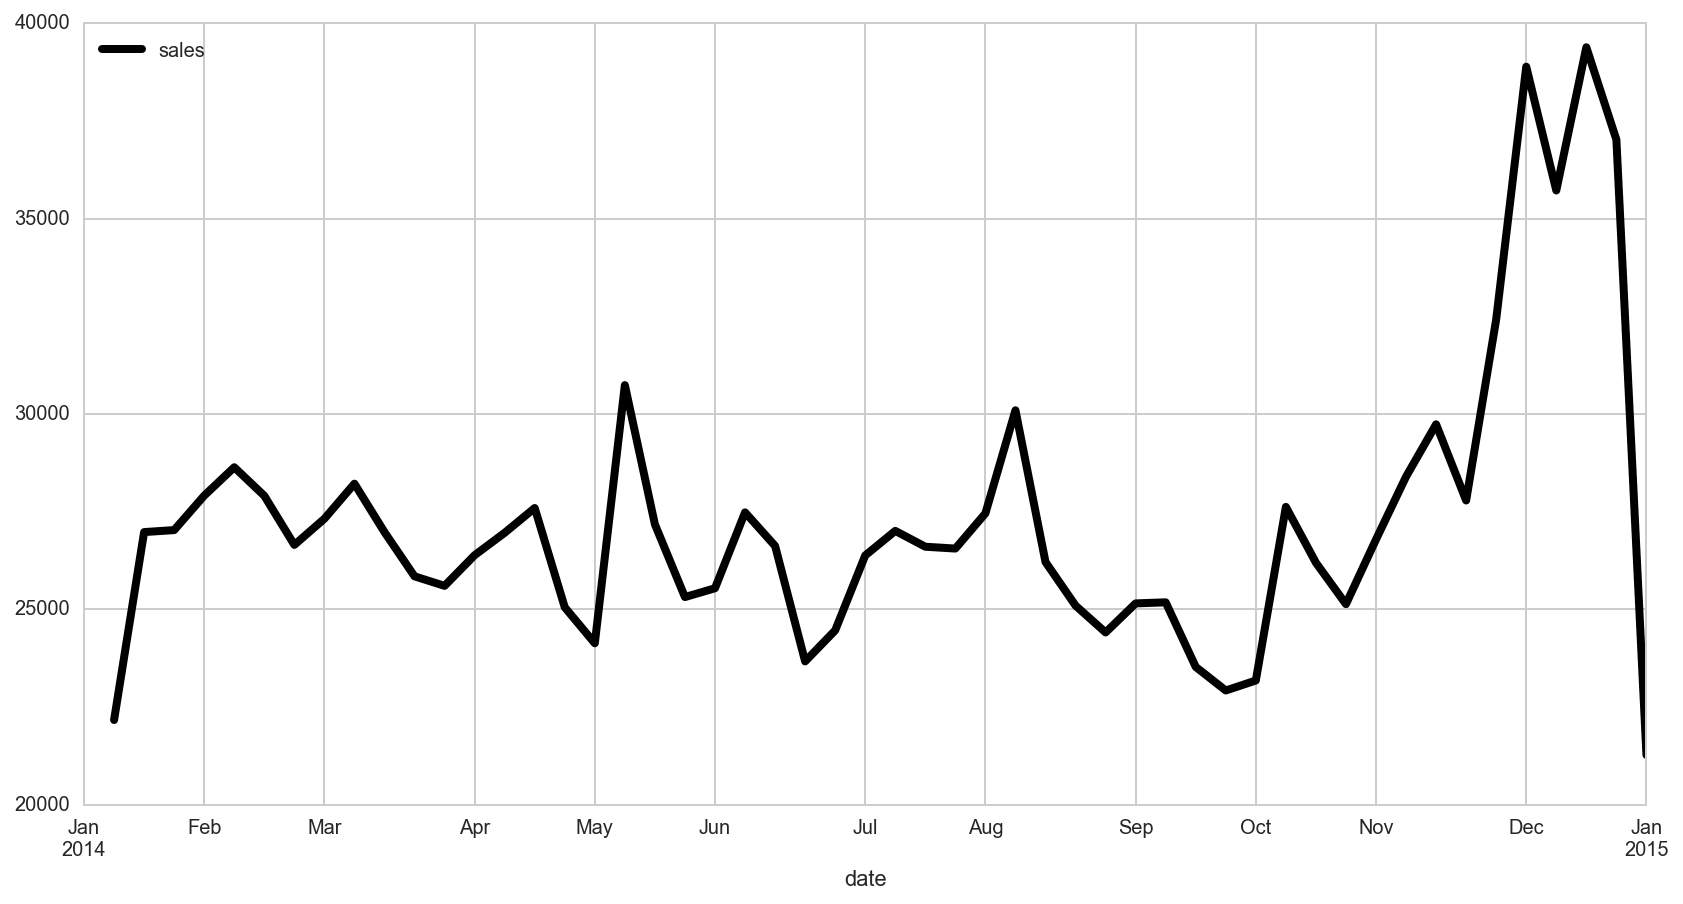

In [28]:
s1_2014[['sales']].resample('W').sum().rolling(window=2, center=True).median().plot(style='k', figsize=(14,7), lw=4)

### Expanding mean

The "expanding mean" simply uses all datapoints up to the current time to calculate the mean, as opposed to a moving window.

**Plot the rolling mean and the expanded mean for store 1 sales in year 2014:**

In [29]:
date_ticks = s1_2014.resample('W').index.to_pydatetime()

rolling_mean = s1_2014[['sales']].resample('W').sum().rolling(window=1, center=True).mean()
expanding_mean = s1_2014[['sales']].resample('W').sum().expanding().mean()

/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:1: FutureWarning: .resample() is now a deferred operation
use .resample(...).mean() instead of .resample(...)
  if __name__ == '__main__':


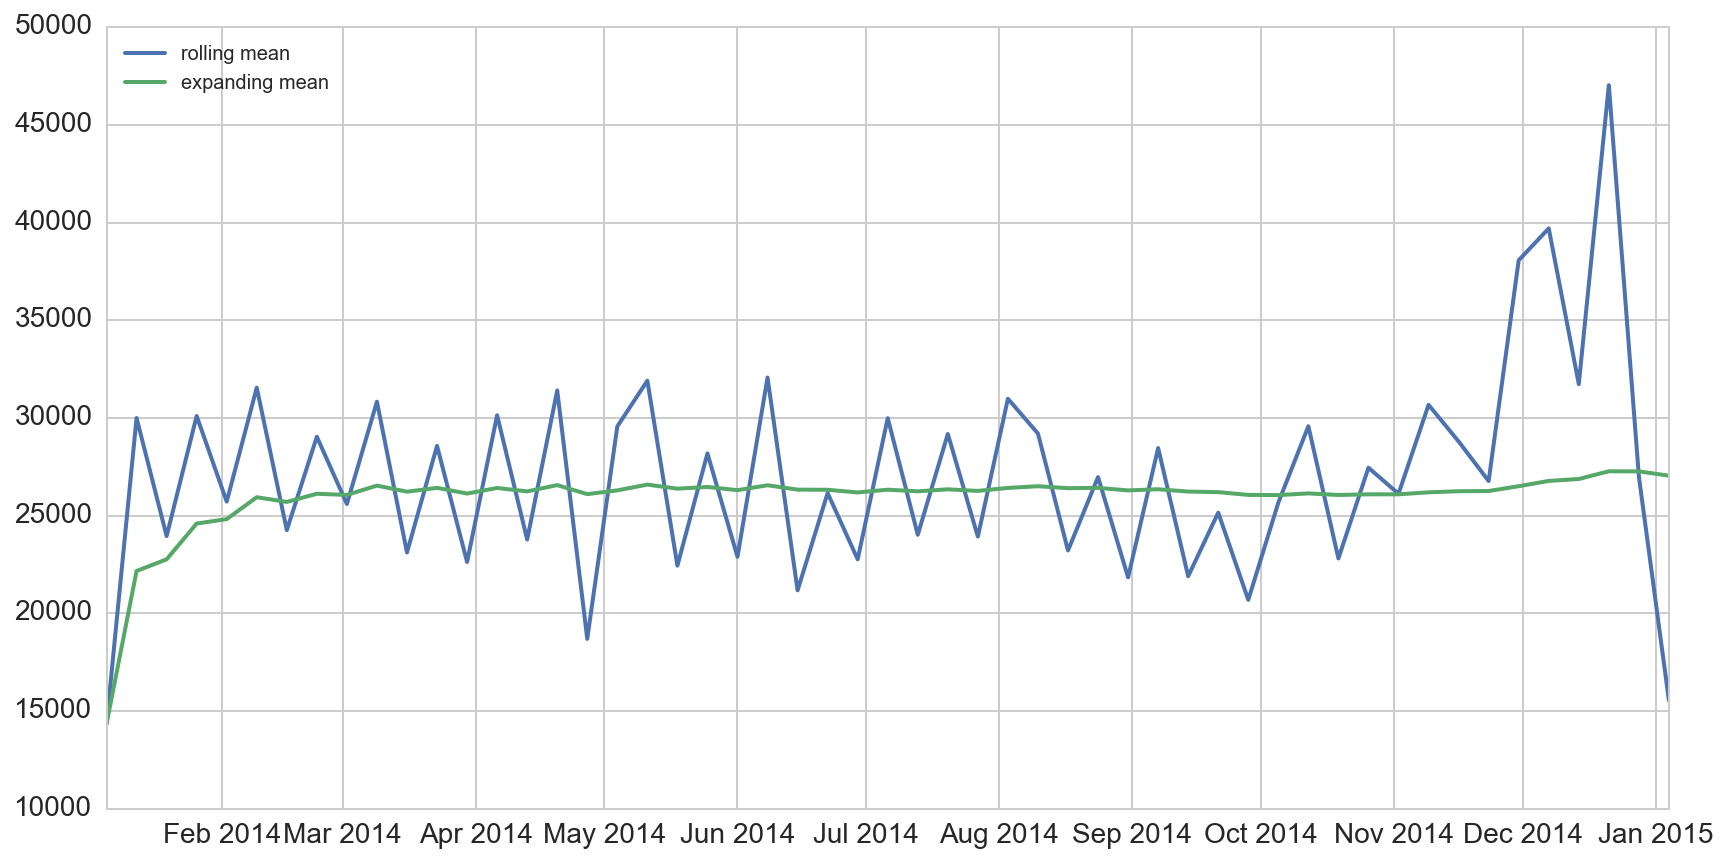

In [30]:
plt.figure(figsize=(14,7))

plt.plot(date_ticks, rolling_mean, alpha=1, lw=2, label='rolling mean')
plt.plot(date_ticks, expanding_mean, alpha=1, lw=2, label='expanding mean')

plt.legend(loc='upper left')

plt.tick_params(labelsize=14)

### Exponentially weighted windows

Exponentially weighted windows are one of the most common and effective ways of averaging out noise in timeseries data. The averaging is done with an "exponential decay" on the contribution of prior means, decreasing the contribution of timepoints further in the past.

The (adjusted) exponentially weighted mean for time $t$ is defined as:

### $$ x_t = \frac{x_t + (1 - \alpha)x_{t-1} + (1 - \alpha)^2x_{t-1} + ... + (1 - \alpha)^{t}x_0} {1 + (1 - \alpha) + (1 - \alpha)^2 + ... + (1 - \alpha)^{t}} $$

See:

http://pandas.pydata.org/pandas-docs/stable/computation.html#exponentially-weighted-windows



**Plot the rolling and exponentially weighted mean of sales data for the winter months of store 1 sales in 2014:**

In [39]:
s1_winter14 = s1_2014[s1_2014.month > 9]

rolling_mean = s1_winter14[['sales']].resample('D').sum().rolling(window=2, center=True).mean()
expanding_mean = s1_winter14[['sales']].resample('D').sum().expanding().mean()
exp_weighted_mean = s1_winter14[['sales']].resample('D').sum().ewm(span=5).mean()


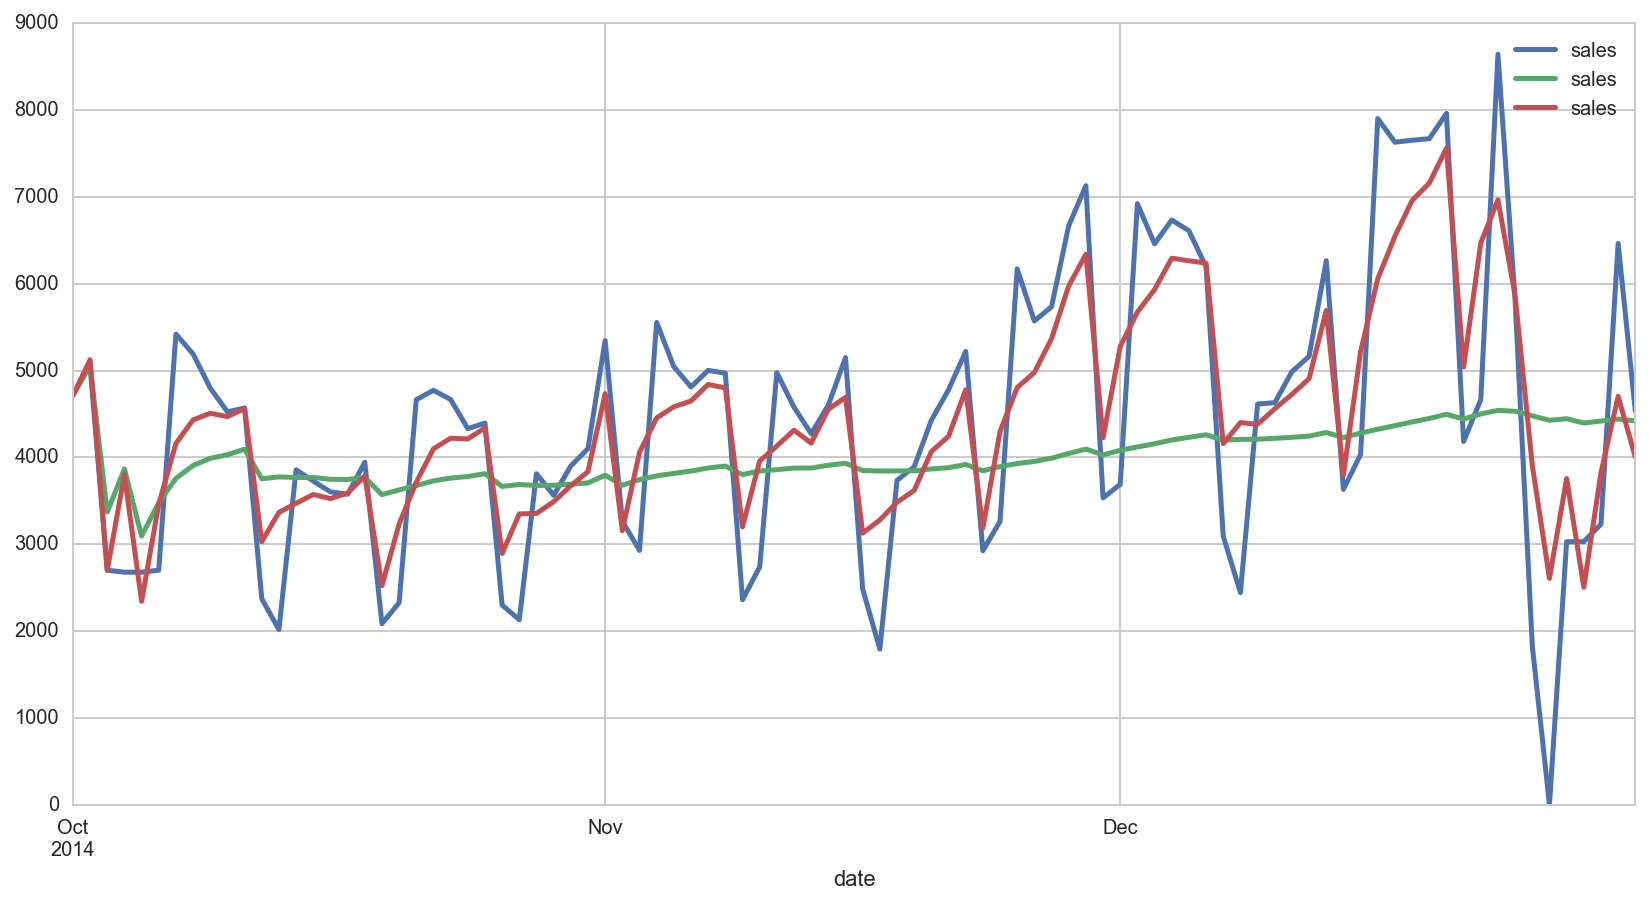

In [40]:
ax = rolling_mean.plot(lw=2.5, figsize=(14,7))
expanding_mean.plot(lw=2.5, ax=ax)
exp_weighted_mean.plot(ax=ax, lw=2.5)

---

##  Autocorrelation and the autocorrelation function (acf)

While in previous weeks, our analyses has been concerned with the correlation between two or more variables (height and weight, education and salary, etc.), in time series data, autocorrelation is a measure of _how correlated a variable is with itself_.

Specifically, autocorrelation measures how closely related earlier values are with values occurring later in time.

Examples of autocorrelation:

    In stock market data the stock price at one point is correlated with the stock 
    price of the point directly prior in time. 
    
    In sales data (like we have seen), sales on a Saturday are likely correlated with 
    sales on the next Saturday and the previous Saturday, as well as other days to more
    or less extent.

Below is the formula for the autocorrelation funtion (acf):

$\text{Given measurements } x_1, x_2, x_3 ... x_n \text{ at time points } t_1, t_2, t_3 ... t_n:$

### $$lag_k\;acf() = \frac{\sum_{t=k+1}^{n}\left(\;x_t - \bar{x}\;\right)\left(\;x_{t-k} - \bar{x}\;\right)}{\sum_{t=1}^n\left(\;x_t - \bar{x}\;\right)^2}$$

Compare this to the formula for correlation:

$\text{Given measurements } x_1, x_2, x_3 ... x_n \text{ aand measurements } y_1, y_2, y_3 ... y_n:$

### $$r_{xy} = \frac{\sum_{i=1}^{n}\left(\;x_i - \bar{x}\;\right)\left(\;y_{i} - \bar{y}\;\right)}{\sqrt{\left(\sum_{i=1}^{n}\left(\;x_i - \bar{x}\;\right)^2\sum_{i=1}^n\left(\;y_i - \bar{y}\;\right)^2\right)}}$$

---

## Computing Autocorrelation

To compute autocorrelation, we fix a lag _k_ which is the delta between the given point and the prior point used to compute the correlation.

With a _k_ value of 1, we'd compute how correlated a value is with the prior one. With a _k_ value of 10, we'd compute how correlated a variable is with one 10 time points earlier.

**Calculate the autocorrelation for store 1 (when open) sales for day and week periods with lag 1:**

In [23]:
s1 = data[(data.store == 1) & (data.open == 1)]
s1.sort_index(ascending=True, inplace=True)

autocorr_day_lag1 = s1['sales'].resample('D').mean().autocorr(lag=1)
autocorr_week_lag1 = s1['sales'].resample('W').mean().autocorr(lag=1)

print autocorr_day_lag1
print autocorr_week_lag1


0.744897317238
-0.0031922367977


/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


**Calculate the autocorrelation for store 1 (including days closed) for day with lag 7:**

In [24]:
s1 = data[(data.store == 1)]
s1.sort_index(ascending=True, inplace=True)

autocorr_day_lag7 = s1['sales'].resample('D').mean().autocorr(lag=7)

print autocorr_day_lag7

0.630719243284


/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


**Calculate the autocorrelation for store 1 through 7 days:**

In [41]:
s1 = data[(data.store == 1)]
s1.sort_index(ascending=True, inplace=True)

s1_autocorrelations = [s1.sales.autocorr(lag=l) for l in range(1,8)]
s1_autocorrelations[0:7]

/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


[-0.12732514339140213,
 -0.034787155707946958,
 0.06473611291299991,
 -0.0018114479109864303,
 -0.10945793528897302,
 -0.22963935576549277,
 0.63071924328402884]

**Plot the autocorrelation for store 1 for 31 days:**

In [42]:
s1_autocorrelations = [s1.sales.autocorr(lag=l) for l in range(1,32)]
s1autocorr = pd.DataFrame({'lag':range(1,32),
                           'autocorrelation':s1_autocorrelations})

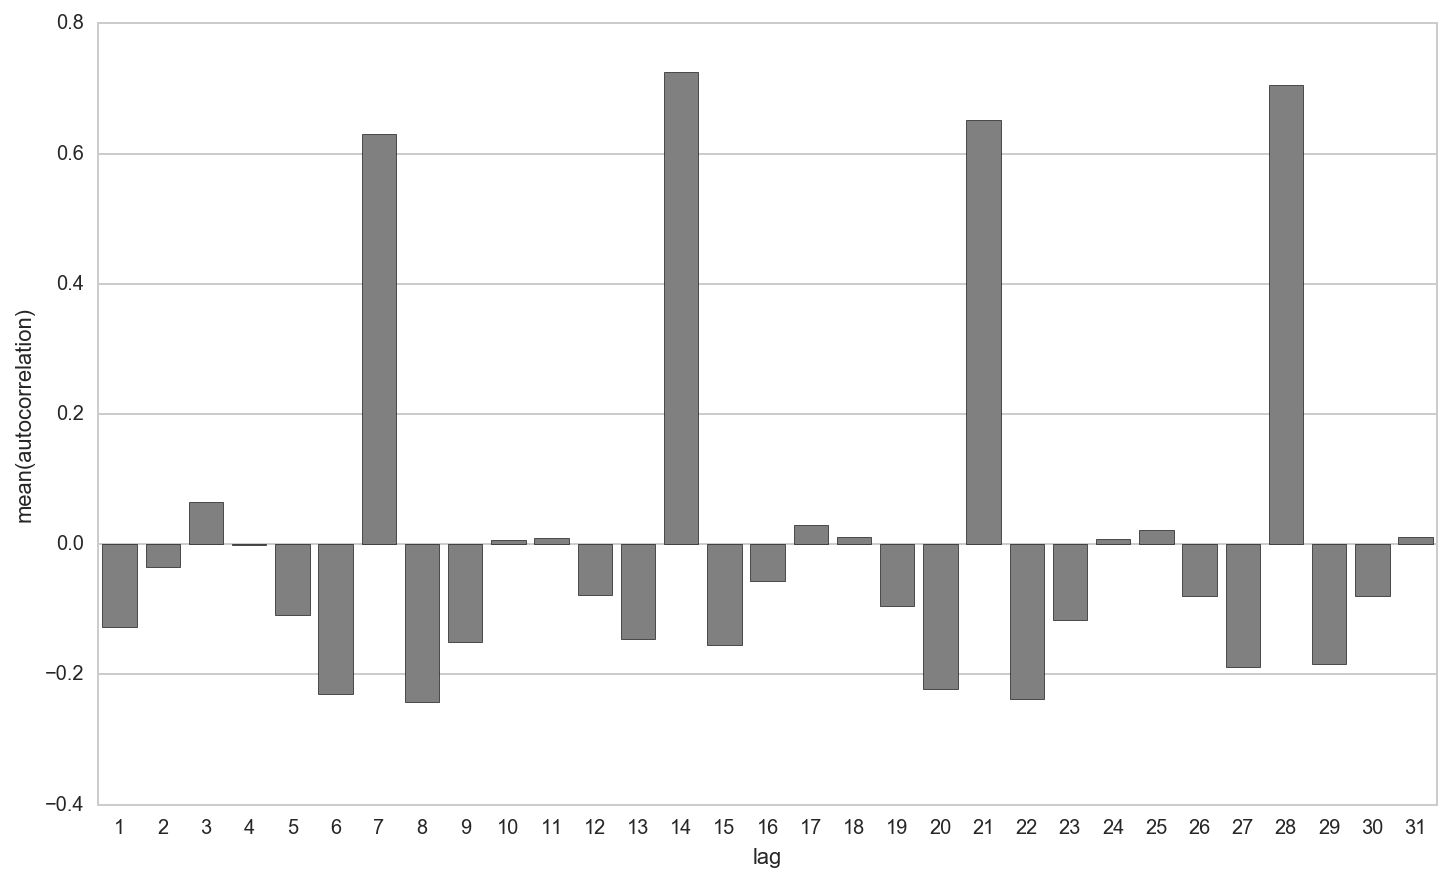

In [43]:
plt.figure(figsize=(12,7))

sns.barplot(x=s1autocorr.lag, y=s1autocorr.autocorrelation, color='grey')

**Load the `acf` and `plot_acf` functions from statsmodels to plot the autocorrelation.**

In [44]:
from statsmodels.tsa.stattools import acf
from statsmodels.graphics.tsaplots import plot_acf

**Calculate and plot the autocorrelation again using the statsmodels functions:**

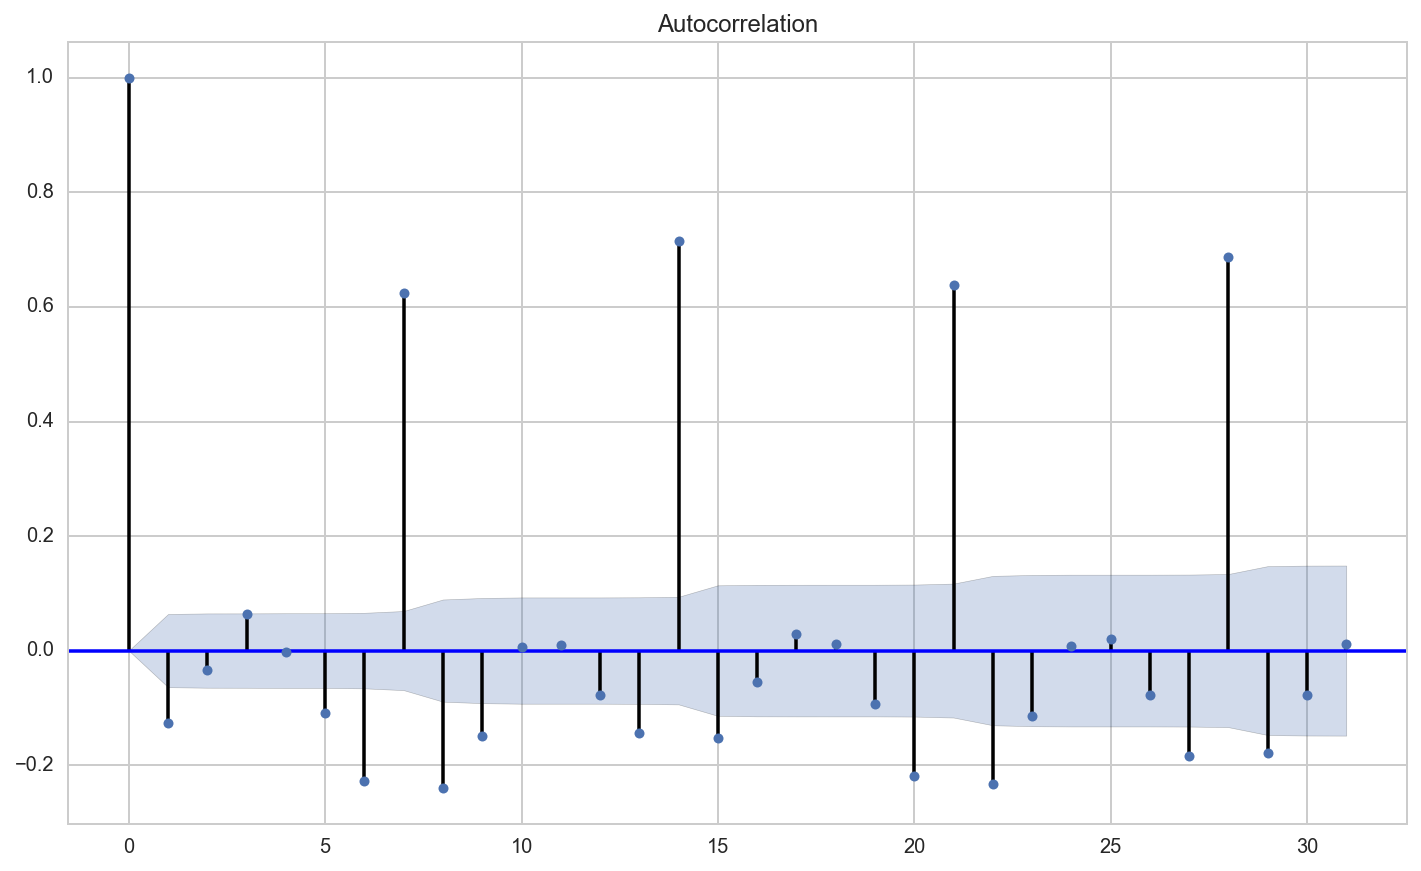

In [45]:
fig = plt.figure(figsize=(12,7))
ax = fig.gca()
plot_acf(s1['sales'].values, lags=31, ax=ax)
plt.show()